In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt


In [17]:
OUTPUT_DIR = Path("../output")
df = pd.read_csv(OUTPUT_DIR / "posts_feature_engineered.csv")
df.head()

,id,subreddit.name,topic,score,log_score,title_length,selftext_length,total_text_length,log_text_length,hour,dayofweek,is_weekend
0,t4f9bf,datasets,1,7,2.079442,21,9,30,3.433987,18,1,0
1,t4euxw,datasets,32,1,0.693147,89,522,611,6.416732,18,1,0
2,t4e0bb,datasets,1,1,0.693147,45,9,54,4.007333,18,1,0
3,t49fq0,datasets,153,1,0.693147,42,177,219,5.393628,14,1,0
4,t47wiw,datasets,6,2,1.098612,79,123,202,5.313206,13,1,0


In [4]:
df.shape

(11208, 12)

In [5]:
df['topic'].nunique()

158

In [6]:
df["score"].describe()

count    11208.000000
mean         5.916934
std         16.173216
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        849.000000
Name: score, dtype: float64

In [18]:
# 토픽별 A/B Test 
def ab_test_topic(df, topic_id, metric="log_score"):
    group_a = df[df["topic"] == topic_id][metric]
    group_b = df[df["topic"] != topic_id][metric]

    if len(group_a) < 30 or len(group_b) < 30:
        return None

    t_stat, p_value = ttest_ind(
        group_a,
        group_b,
        equal_var=False
    )

    return {
        "topic": topic_id,
        "mean_A": group_a.mean(),
        "mean_B": group_b.mean(),
        "diff": group_a.mean() - group_b.mean(),
        "p_value": p_value,
        "n_A": len(group_a),
        "n_B": len(group_b)
    }

In [19]:
results = []

for t in sorted(df["topic"].unique()):
    res = ab_test_topic(df, t)
    if res is not None:
        results.append(res)

ab_df = pd.DataFrame(results)

ab_df.head()

,topic,mean_A,mean_B,diff,p_value,n_A,n_B
0,0,1.069489,1.388458,-0.318968,7.749805e-56,2411,8797
1,1,0.846492,1.418371,-0.571878,9.032535e-213,1931,9277
2,2,1.521499,1.313534,0.207965,2.174686e-05,340,10868
3,3,2.106002,1.305196,0.800806,8.707965e-18,205,11003
4,4,1.635399,1.314197,0.321202,1.412933e-06,197,11011


In [20]:
ab_df["p_adj"] = multipletests(
    ab_df["p_value"],
    method="fdr_bh"
)[1]


In [21]:
ab_df["significant"] = ab_df["p_adj"] < 0.05
ab_df["effect_direction"] = np.where(
    ab_df["diff"] > 0, "positive", "negative"
)

In [22]:
ab_df.to_csv(
    OUTPUT_DIR / "ab_test_results.csv",
    index=False
)

In [24]:
summary = (
    ab_df
    .groupby("significant")["diff"]
    .mean()
    .reset_index()
)

summary

,significant,diff
0,False,0.095842
1,True,0.351924


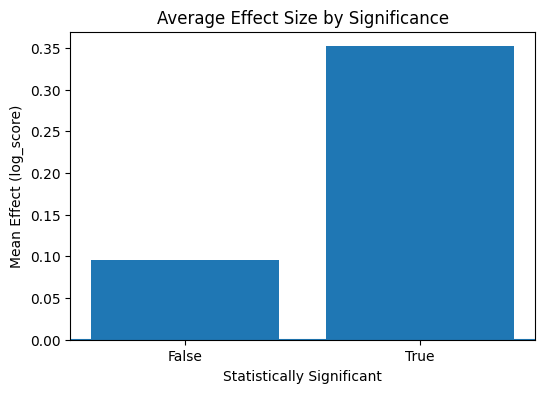

In [25]:
plt.figure(figsize=(6, 4))
plt.bar(summary["significant"].astype(str), summary["diff"])
plt.axhline(0)
plt.xlabel("Statistically Significant")
plt.ylabel("Mean Effect (log_score)")
plt.title("Average Effect Size by Significance")
plt.show()

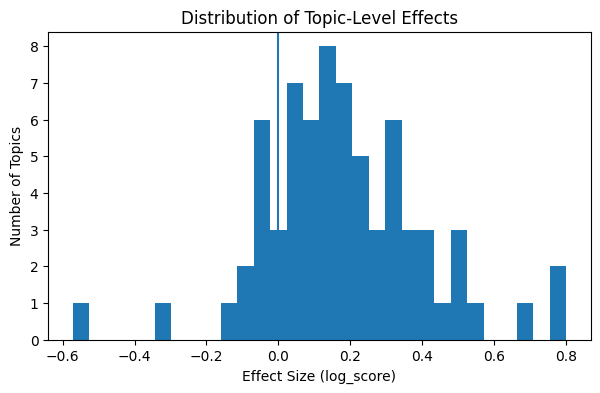

In [26]:
plt.figure(figsize=(7, 4))
plt.hist(ab_df["diff"], bins=30)
plt.axvline(0)
plt.xlabel("Effect Size (log_score)")
plt.ylabel("Number of Topics")
plt.title("Distribution of Topic-Level Effects")
plt.show()

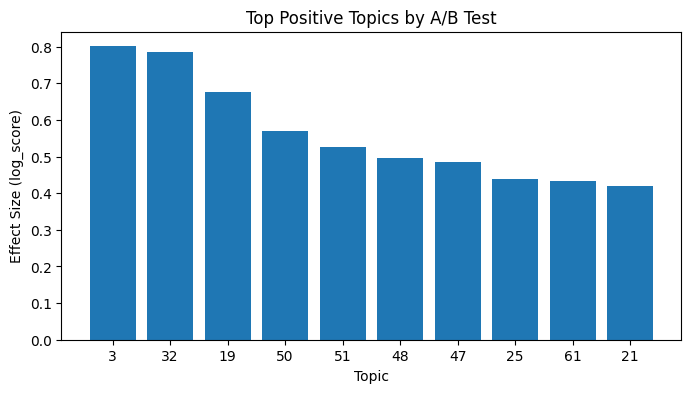

In [27]:
top_topics = (
    ab_df[
        (ab_df["significant"]) &
        (ab_df["diff"] > 0)
    ]
    .sort_values("diff", ascending=False)
    .head(10)
)

plt.figure(figsize=(8, 4))
plt.bar(top_topics["topic"].astype(str), top_topics["diff"])
plt.xlabel("Topic")
plt.ylabel("Effect Size (log_score)")
plt.title("Top Positive Topics by A/B Test")
plt.show()
